# Predicting the Presence of Lung Cancer

# Problem Definition
> How well can we predict whether there is lung cancer

We'll try to get an accuracy of over 95%, since this is important

# Data

The data is taken from kaggle: https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, classification_report

In [2]:
lung_data = pd.read_csv('data.csv')
lung_data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [3]:
lung_data.shape

(309, 16)

In [5]:
lung_data.isnull().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

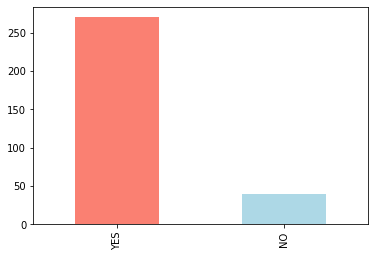

In [10]:
# Check for data imbalance
lung_data['LUNG_CANCER'].value_counts().plot(kind='bar', color=['salmon', 'lightblue']);

Data is quite imbalanced: therefore we will sample the 'NO' diagnosis

In [16]:
lung_data[lung_data['LUNG_CANCER'] == 'YES'].shape[0]

270

In [17]:
# Upsample minority class
no_upsampled = resample(
    lung_data[lung_data['LUNG_CANCER'] == 'NO'], 
    replace=True,
    n_samples=lung_data[lung_data['LUNG_CANCER'] == 'YES'].shape[0],
    random_state=123
)

In [19]:
no_upsampled.shape

(270, 16)

In [20]:
# Create balanced dataset
lung_data_sampled = pd.concat([lung_data[lung_data['LUNG_CANCER'] == 'YES'], no_upsampled])

In [21]:
lung_data_sampled.shape

(540, 16)

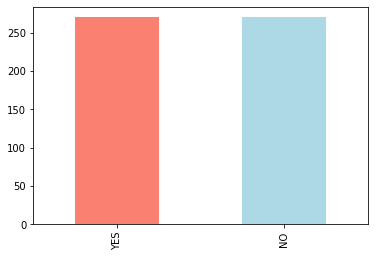

In [23]:
# Check for data imbalance
lung_data_sampled['LUNG_CANCER'].value_counts().plot(kind='bar', color=['salmon', 'lightblue']);

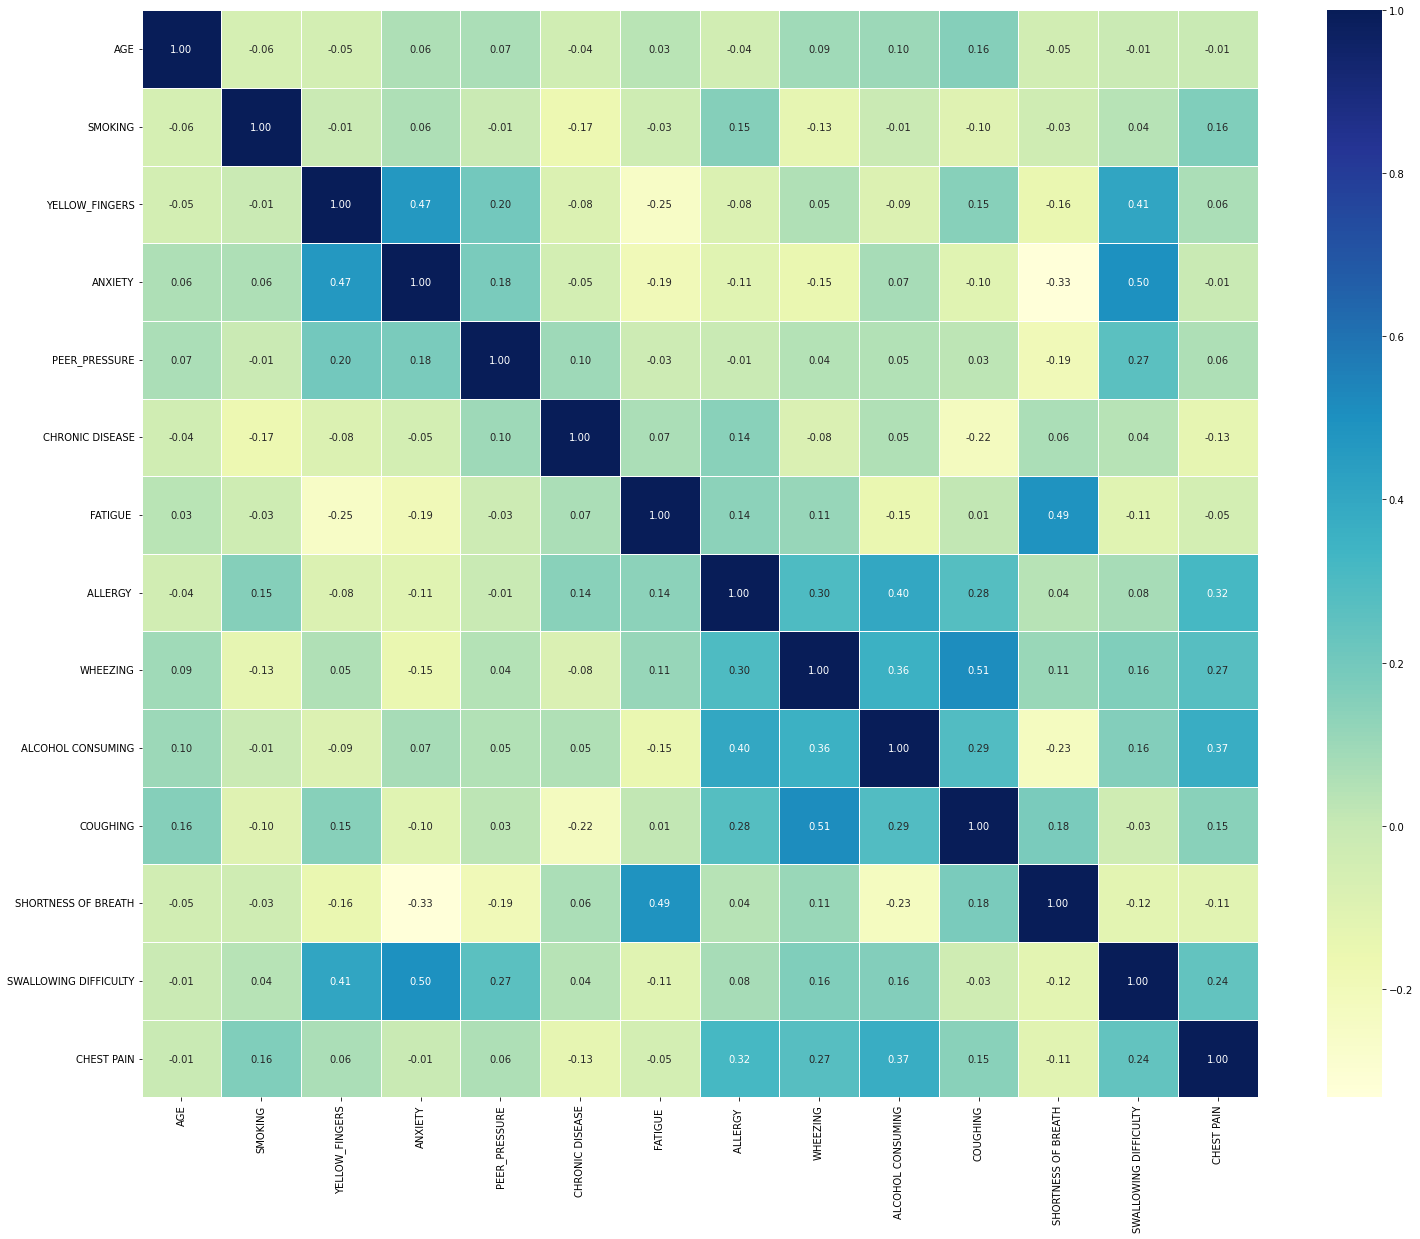

In [25]:
# Plot correlation matrix
corr_matrix = lung_data_sampled.corr()
fig, ax = plt.subplots(figsize=(25, 20))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
    cmap="YlGnBu"
);

No highly correlated features

In [26]:
lung_data_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540 entries, 0 to 80
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 540 non-null    object
 1   AGE                    540 non-null    int64 
 2   SMOKING                540 non-null    int64 
 3   YELLOW_FINGERS         540 non-null    int64 
 4   ANXIETY                540 non-null    int64 
 5   PEER_PRESSURE          540 non-null    int64 
 6   CHRONIC DISEASE        540 non-null    int64 
 7   FATIGUE                540 non-null    int64 
 8   ALLERGY                540 non-null    int64 
 9   WHEEZING               540 non-null    int64 
 10  ALCOHOL CONSUMING      540 non-null    int64 
 11  COUGHING               540 non-null    int64 
 12  SHORTNESS OF BREATH    540 non-null    int64 
 13  SWALLOWING DIFFICULTY  540 non-null    int64 
 14  CHEST PAIN             540 non-null    int64 
 15  LUNG_CANCER            5

In [42]:
# Convert gender and lung_cancer to categories
lung_data_sampled['GENDER'].replace('F', 0, inplace=True)
lung_data_sampled['GENDER'].replace('M', 1, inplace=True)
lung_data_sampled['LUNG_CANCER'] = lung_data_sampled['LUNG_CANCER'].astype('category')

In [43]:
lung_data_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540 entries, 0 to 80
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   GENDER                 540 non-null    category
 1   AGE                    540 non-null    int64   
 2   SMOKING                540 non-null    int64   
 3   YELLOW_FINGERS         540 non-null    int64   
 4   ANXIETY                540 non-null    int64   
 5   PEER_PRESSURE          540 non-null    int64   
 6   CHRONIC DISEASE        540 non-null    int64   
 7   FATIGUE                540 non-null    int64   
 8   ALLERGY                540 non-null    int64   
 9   WHEEZING               540 non-null    int64   
 10  ALCOHOL CONSUMING      540 non-null    int64   
 11  COUGHING               540 non-null    int64   
 12  SHORTNESS OF BREATH    540 non-null    int64   
 13  SWALLOWING DIFFICULTY  540 non-null    int64   
 14  CHEST PAIN             540 non-null    int6

In [44]:
lung_data_sampled.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
5,0,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES
6,1,52,2,1,1,1,1,2,1,2,2,2,2,1,2,YES
7,0,51,2,2,2,2,1,2,2,1,1,1,2,2,1,YES


# Modelling

In [46]:
X = lung_data_sampled.drop('LUNG_CANCER', axis=1)
y = lung_data_sampled['LUNG_CANCER']

X.shape, y.shape

((540, 15), (540,))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((432, 15), (108, 15), (432,), (108,))

In [52]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': LinearSVC(max_iter=1000000)
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [53]:
fit_and_score(
    models,
    X_train,
    X_test,
    y_train,
    y_test
)

{'Logistic Regression': 0.9074074074074074,
 'KNN': 0.9259259259259259,
 'Random Forest': 1.0,
 'SVM': 0.9166666666666666}

Random Forest has the best score

In [54]:
# Tune hyperparameters

rf_grid = {
    'n_estimators': np.arange(10, 20, 10),
    'max_depth': [None, 3, 5],
    'min_samples_split': np.arange(10, 50, 10),
    'min_samples_leaf': np.arange(10, 50, 10)
}

In [56]:
# tune Random Forest
np.random.seed(42)

rf_gs = GridSearchCV(
    RandomForestClassifier(),
    rf_grid
)

rf_gs.fit(X_train, y_train)
rf_gs.score(X_test, y_test), rf_gs.best_params_

(0.8703703703703703,
 {'max_depth': 3,
  'min_samples_leaf': 10,
  'min_samples_split': 20,
  'n_estimators': 10})

# Evaluation

In [57]:
y_preds = rf_gs.predict(X_test)
y_preds_proba = rf_gs.predict_proba(X_test)

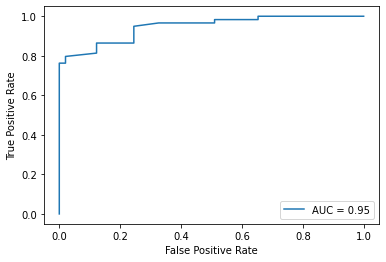

In [58]:
# Plot ROC curve and calculate and calculate AUC metric
fpr, tpr, thresholds = roc_curve(y_test, y_preds_proba[:,1], pos_label='YES')
auc_score = roc_auc_score(y_test, y_preds_proba[:,1])
plot_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
plot_roc.plot();

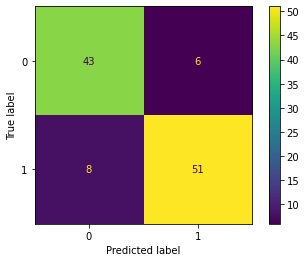

In [59]:
# Plot confusion matrix
confusion_matrix = confusion_matrix(y_test, y_preds)
plot_cm = ConfusionMatrixDisplay(confusion_matrix)
plot_cm.plot();

In [60]:
# Produce classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

          NO       0.84      0.88      0.86        49
         YES       0.89      0.86      0.88        59

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.87      0.87      0.87       108



# Cross-Validation Evaluation

In [61]:
cross_rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=20
)

cross_score = cross_val_score(
    estimator=cross_rf,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy'
)

np.mean(cross_score)

0.8925925925925926

In [62]:
pos_neg_labels = list(map(lambda x: 1 if x == 'YES' else 0, y))

In [63]:
cross_precision = cross_val_score(
    estimator=cross_rf,
    X=X,
    y=pos_neg_labels,
    cv=5,
    scoring='precision'
)

np.mean(cross_precision)

0.9014048717240207

In [64]:
cross_recall = cross_val_score(
    estimator=cross_rf,
    X=X,
    y=pos_neg_labels,
    cv=5,
    scoring='recall'
)

np.mean(cross_recall)

0.874074074074074

In [65]:
cross_f1 = cross_val_score(
    estimator=cross_rf,
    X=X,
    y=pos_neg_labels,
    cv=5,
    scoring='f1'
)

np.mean(cross_f1)

0.88060726671201